In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from tqdm import tqdm

CSV_FILE = 'dataset_preparation_results.csv'

os.chdir('./crawler')

def check_image(file_path):
    try:
        with Image.open(file_path) as img:
            width, height = img.size
            return True, width, height
    except:
        return False, None, None

def analyze_images(df):
    results = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        file_path = row['File Path']
        if os.path.exists(file_path):
            is_valid, width, height = check_image(file_path)
            if is_valid:
                aspect_ratio = width / height if height != 0 else None
            else:
                aspect_ratio = None
        else:
            is_valid = False
            aspect_ratio = None
        results.append({'is_valid': is_valid, 'aspect_ratio': aspect_ratio})
    return pd.DataFrame(results)


df = pd.read_csv(CSV_FILE)

results = analyze_images(df)
df = pd.concat([df, results], axis=1)

invalid_count = df['is_valid'].value_counts()[False]
print(f"Number of invalid images: {invalid_count}")

unusual_ratios = df[(df['aspect_ratio'] < 0.5) | (df['aspect_ratio'] > 2)]
print("\nImages with unusual aspect ratios:")
print(unusual_ratios[['File Path', 'aspect_ratio']])


100%|██████████| 81186/81186 [00:15<00:00, 5286.11it/s]


Number of invalid images: 88

Images with unusual aspect ratios:
                                               File Path  aspect_ratio
27     images/462/402462/402462_xyz_grid-0078-3618294...      4.205607
28     images/462/402462/402462_xyz_grid-0055-3365002...      4.205607
29     images/462/402462/402462_xyz_grid-0039-4024633...      4.205607
30     images/462/402462/402462_xyz_grid-0003-2452870...      4.205607
129    images/615/308615/308615_xyz_grid-0000-3106564...      2.445652
...                                                  ...           ...
78091  images/860/547860/547860_5f02faa6f2f78f6ad84ad...      2.500000
79264   images/817/546817/546817_pixelcut-export.png.jpg      0.412088
79921  images/301/594301/594301_00029-3376956965.png.jpg      2.343750
79922  images/301/594301/594301_00034-3955201973.png.jpg      2.343750
79989  images/029/536029/536029_xyz_grid-0014-1370467...      3.409091

[212 rows x 2 columns]


(0.0, 3.0)

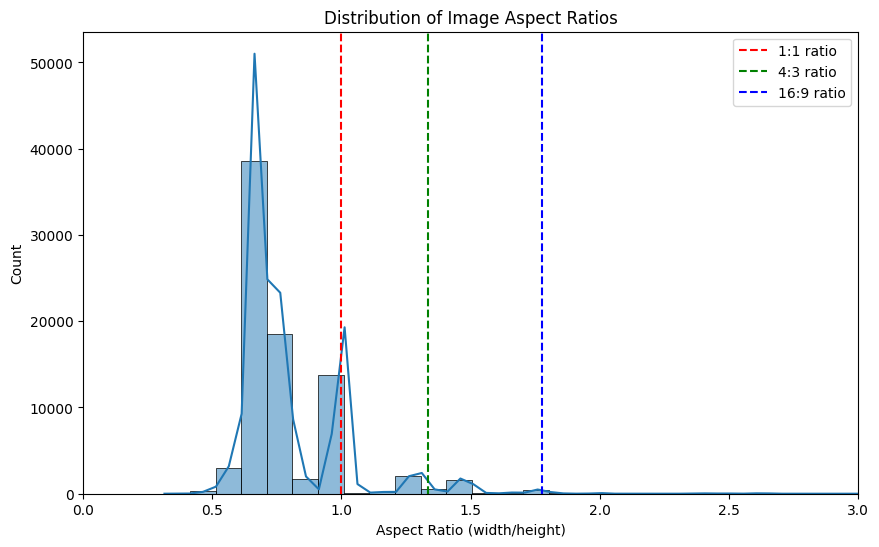

In [2]:
valid_ratios = df[df['aspect_ratio'].notnull()]['aspect_ratio']
plt.figure(figsize=(10, 6))
sns.histplot(valid_ratios, bins=100, kde=True)
plt.title('Distribution of Image Aspect Ratios')
plt.xlabel('Aspect Ratio (width/height)')
plt.ylabel('Count')
plt.axvline(x=1, color='r', linestyle='--', label='1:1 ratio')
plt.axvline(x=4/3, color='g', linestyle='--', label='4:3 ratio')
plt.axvline(x=16/9, color='b', linestyle='--', label='16:9 ratio')
plt.legend()
plt.xlim(0, 3)

Text(0, 0.5, 'Count')

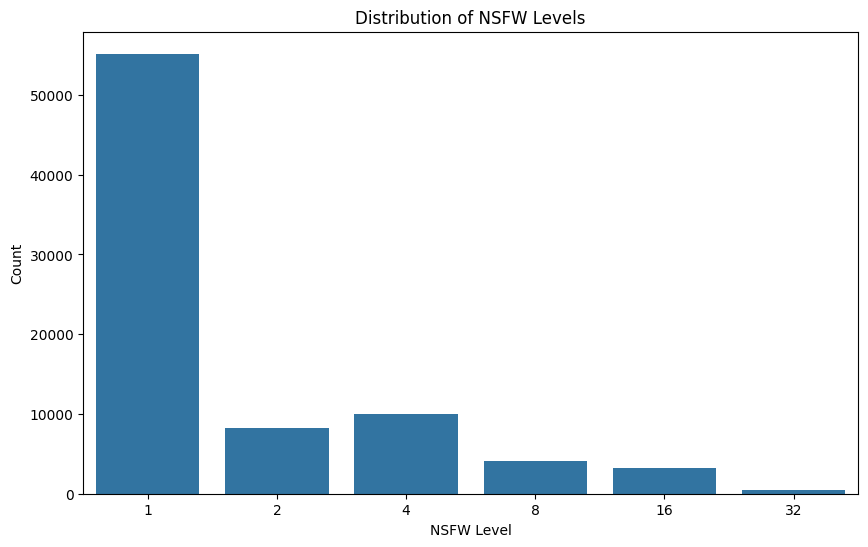

In [3]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Original NSFW Level', data=df)
plt.title('Distribution of NSFW Levels')
plt.xlabel('NSFW Level')
plt.ylabel('Count')

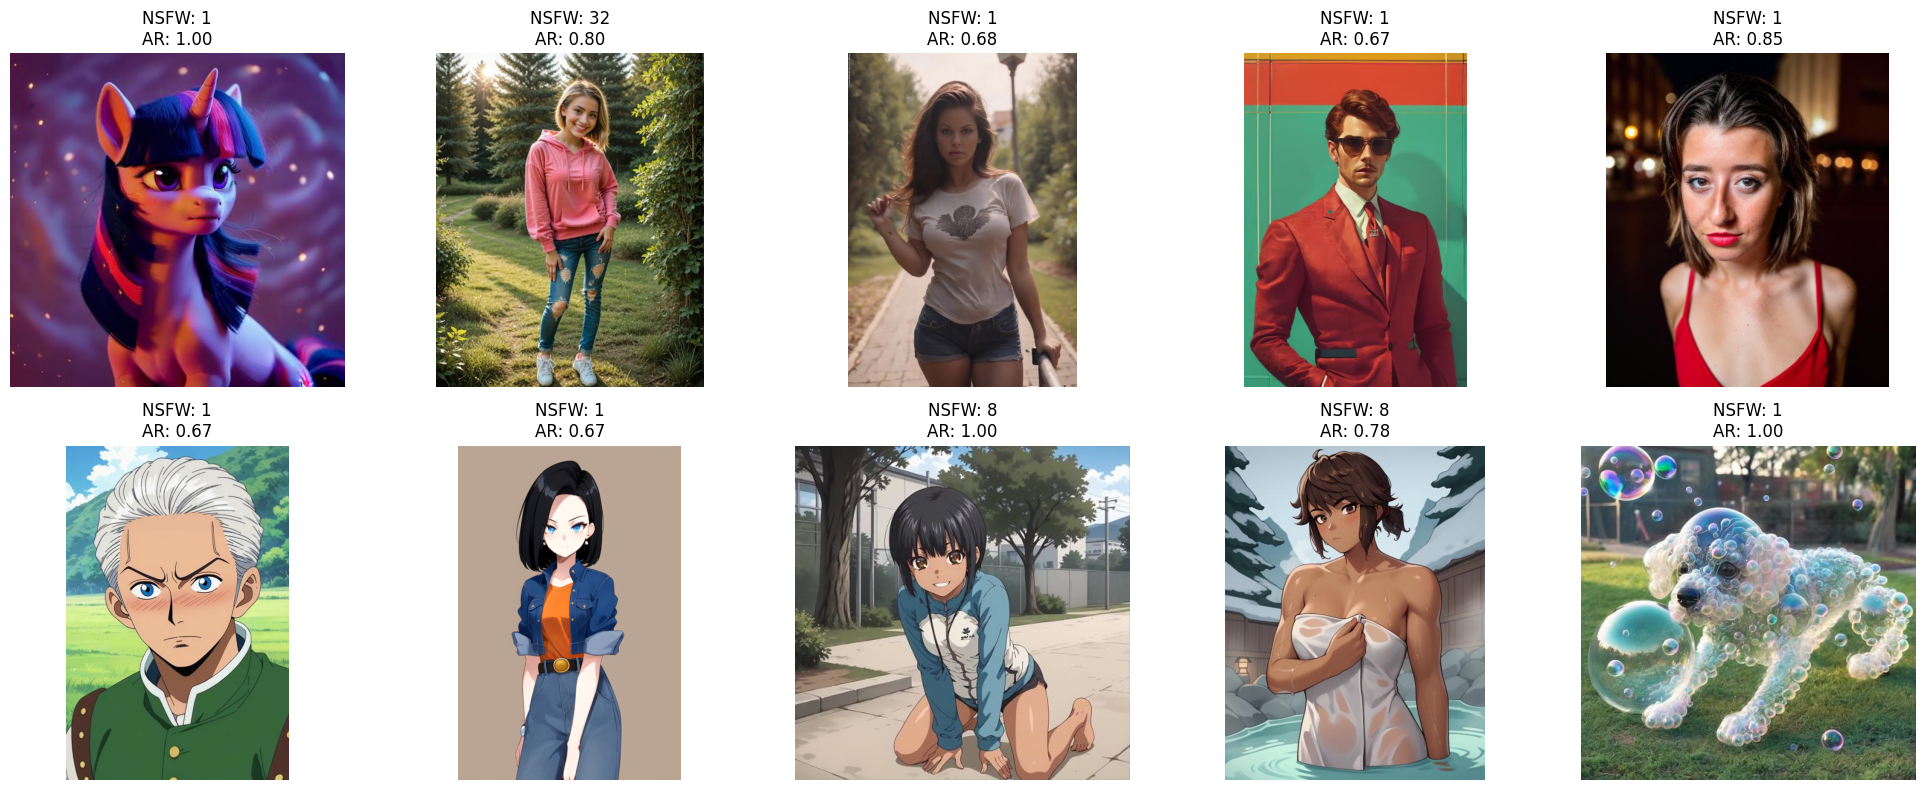

In [4]:
def plot_random_images(df, num_images=10):
    # Filter out effective images
    valid_images = df[df['is_valid'] == True]
    
    # If the number of valid images is less than the number of requests, all valid images are used.
    num_images = min(num_images, len(valid_images))
    
    # Select images randomly
    selected_images = valid_images.sample(n=num_images)
    
    # Create Subgraphs
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for i, (_, row) in enumerate(selected_images.iterrows()):
        img = Image.open(row['File Path'])
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"NSFW: {row['Original NSFW Level']}\nAR: {row['aspect_ratio']:.2f}")
    
    plt.tight_layout()


plot_random_images(df, 10)

In [5]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import random
from PIL import Image
from sklearn.model_selection import GroupShuffleSplit

class ContrastiveDataset(Dataset):
    def __init__(self, df, transform=None):
        self.data = df.reset_index(drop=True)

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = row['File Path']
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Create positive pairs for contrastive learning
        positive_idx = self.find_positive_pair(idx)
        try:
            positive_row = self.data.iloc[positive_idx]
        except:
            print(positive_idx, len(self.data))
        positive_image_path = positive_row['File Path']
        positive_image = Image.open(positive_image_path).convert('RGB')

        if self.transform:
            positive_image = self.transform(positive_image)

        return image, positive_image

    def find_positive_pair(self, idx):
        
        current_row = self.data.iloc[idx]
        
        # Strategy 1: Images with the same Model ID
        same_model = self.data[self.data['Model ID'] == current_row['Model ID']]
        
        # nsfw_level = current_row['Original NSFW Level']
        # similar_nsfw = self.data[
        #     (self.data['Original NSFW Level'] >= nsfw_level - 1) &
        #     (self.data['Original NSFW Level'] <= nsfw_level + 1)
        # ]
        
        # Strategy 3: Pictures of the same Creator
        same_creator = self.data[self.data['Creator'] == current_row['Creator']]
        
        # Merge all possible positive pairs and remove the current image.
        potential_pairs = pd.concat([same_model, same_creator])
        potential_pairs = potential_pairs[potential_pairs.index != idx]
        
        # If it cannot find a suitable pair, choose one at random (besides itself)
        if len(potential_pairs) == 0:
            potential_pairs = self.data[self.data.index != idx]
        
        # Select a positive pair randomly
        return random.choice(potential_pairs.index)

In [6]:

def split_data(df, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    # Ensure that the sum of the ratios is 1
    assert np.isclose(train_size + val_size + test_size, 1.0)
    
    # Use GroupShuffleSplit for segmentation to ensure that images with the same Model ID are in the same collection
    gss = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=random_state)
    train_idx, temp_idx = next(gss.split(df, groups=df['Model ID']))
    
    # Further divide the remaining data into validation and test sets
    val_ratio = val_size / (val_size + test_size)
    gss_val = GroupShuffleSplit(n_splits=1, train_size=val_ratio, random_state=random_state)
    val_idx, test_idx = next(gss_val.split(df.iloc[temp_idx], groups=df.iloc[temp_idx]['Model ID']))
    
    # Convert Index
    val_idx = temp_idx[val_idx]
    test_idx = temp_idx[test_idx]
    
    return df.iloc[train_idx], df.iloc[val_idx], df.iloc[test_idx]

# Split data

df = df[df['is_valid'] == True].reset_index(drop=True)

train_df, val_df, test_df = split_data(df)


In [7]:
# Define Data Conversions
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and data loaders
train_dataset = ContrastiveDataset(train_df, transform=transform)
val_dataset = ContrastiveDataset(val_df, transform=transform)
test_dataset = ContrastiveDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8)


In [8]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


# Define the model and loss function
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Identity() 

model = model.to(device)
criterion = torch.nn.CosineSimilarity(dim=1).to(device)

# Define the Optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# Training cycle
def train(model, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_idx, (images, positive_images) in enumerate(tqdm(train_loader, total=len(train_loader))):
            images, positive_images = images.to(device), positive_images.to(device)
            # Forward Propagation
            features = model(images)
            positive_features = model(positive_images)

            # Calculate similarity and loss
            similarity = criterion(features, positive_features)
            loss = -torch.mean(similarity) 

            # Backward Propagation and optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validate
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, positive_images in val_loader:
                images, positive_images = images.to(device), positive_images.to(device)
                features = model(images)
                positive_features = model(positive_images)
                similarity = criterion(features, positive_features)
                loss = -torch.mean(similarity)
                val_loss += loss.item()
        
        print(f'Epoch {epoch}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}')


train(model, train_loader, val_loader, epochs=2)

def test(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for images, positive_images in test_loader:
            images, positive_images = images.to(device), positive_images.to(device)
            features = model(images)
            positive_features = model(positive_images)
            similarity = criterion(features, positive_features)
            loss = -torch.mean(similarity)
            test_loss += loss.item()
    print(f'Test Loss: {test_loss/len(test_loader)}')

test(model, test_loader)

/home/san/miniforge3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/san/miniforge3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 1777/1777 [05:09<00:00,  5.74it/s]


Epoch 0, Train Loss: -0.979802449164125, Val Loss: -0.9998205532787969


100%|██████████| 1777/1777 [05:08<00:00,  5.75it/s]


Epoch 1, Train Loss: -0.9999215245649394, Val Loss: -0.9999662831662193
Test Loss: -0.9999660713107963


Extracting features:  74%|███████▍  | 282/380 [00:19<00:06, 15.21it/s]

Calculating distances: 100%|██████████| 1305/1305 [00:44<00:00, 29.23it/s]


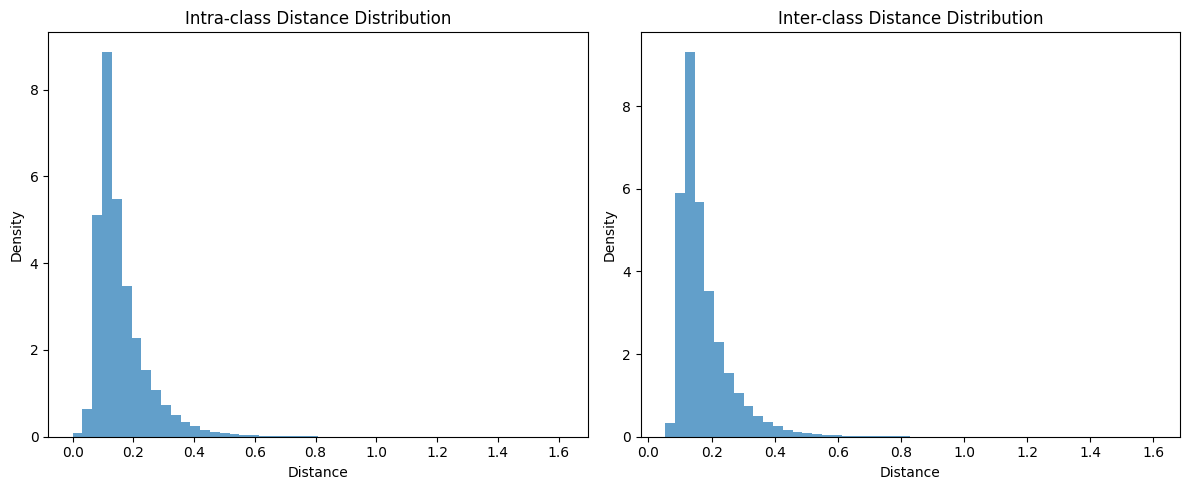

Intra-class distance: mean = 0.1602, std = 0.0914
Inter-class distance: mean = 0.1756, std = 0.0882


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def analyze_distances(model, dataloader, device):
    model.eval()
    features = []
    labels = []
    
    # Extract features and labels
    with torch.no_grad():
        acc =0

        for images, _ in tqdm(dataloader, desc="Extracting features"):
            images = images.to(device)
            output = model(images)
            features.append(output.cpu().numpy())
            idxs = np.arange(len(images)) + acc
            acc += len(images)

            labels.extend(dataloader.dataset.data.iloc[idxs]['Model ID'].tolist())
    
    features = np.vstack(features)
    labels = np.array(labels)
    
    intra_class_distances = []
    inter_class_distances = []
    
    for label in tqdm(np.unique(labels), desc="Calculating distances"):
        class_features = features[labels == label]
        other_features = features[labels != label]
        
        # Calculate intra-class distances
        if len(class_features) > 1:
            intra_distances = np.linalg.norm(class_features[:, None, :] - class_features[None, :, :], axis=-1)
            intra_class_distances.extend(intra_distances[np.triu_indices(len(class_features), k=1)])
        
        # Calculate inter-class distances (to 10 random samples from other classes)
        if len(other_features) > 0:
            random_indices = np.random.choice(len(other_features), min(10, len(other_features)), replace=False)
            inter_distances = np.linalg.norm(class_features[:, None, :] - other_features[random_indices][None, :, :], axis=-1)
            inter_class_distances.extend(inter_distances.flatten())
    
    # Plot distributions
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(intra_class_distances, bins=50, density=True, alpha=0.7)
    plt.title("Intra-class Distance Distribution")
    plt.xlabel("Distance")
    plt.ylabel("Density")
    
    plt.subplot(1, 2, 2)
    plt.hist(inter_class_distances, bins=50, density=True, alpha=0.7)
    plt.title("Inter-class Distance Distribution")
    plt.xlabel("Distance")
    plt.ylabel("Density")
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Intra-class distance: mean = {np.mean(intra_class_distances):.4f}, std = {np.std(intra_class_distances):.4f}")
    print(f"Inter-class distance: mean = {np.mean(inter_class_distances):.4f}, std = {np.std(inter_class_distances):.4f}")

# Usage example:
analyze_distances(model, test_loader, device)

In [10]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import random

class ContrastiveDataset(Dataset):
    def __init__(self, df, transform=None, num_negatives=1):
        self.data = df.reset_index(drop=True)
        self.transform = transform
        self.num_negatives = num_negatives

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        anchor_row = self.data.iloc[idx]
        anchor_image = self.load_image(anchor_row['File Path'])

        positive_idx = self.find_positive_pair(idx)
        positive_row = self.data.iloc[positive_idx]
        positive_image = self.load_image(positive_row['File Path'])

        negative_images = []
        for _ in range(self.num_negatives):
            negative_idx = self.find_negative_pair(idx, positive_idx)
            negative_row = self.data.iloc[negative_idx]
            negative_image = self.load_image(negative_row['File Path'])
            negative_images.append(negative_image)

        return anchor_image, positive_image, negative_images

    def load_image(self, image_path):
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

    def find_positive_pair(self, idx):
        current_row = self.data.iloc[idx]
        same_model = self.data[self.data['Model ID'] == current_row['Model ID']]
        same_creator = self.data[self.data['Creator'] == current_row['Creator']]
        
        potential_pairs = pd.concat([same_model, same_creator])
        potential_pairs = potential_pairs[potential_pairs.index != idx]
        
        if len(potential_pairs) == 0:
            potential_pairs = self.data[self.data.index != idx]
        
        return random.choice(potential_pairs.index)

    def find_negative_pair(self, anchor_idx, positive_idx):
        anchor_row = self.data.iloc[anchor_idx]
        
        # Find images with different Model ID and Creator
        negative_candidates = self.data[
            (self.data['Model ID'] != anchor_row['Model ID']) & 
            (self.data['Creator'] != anchor_row['Creator'])
        ]
        
        if len(negative_candidates) == 0:
            # If no suitable negatives found, choose any image except anchor and positive
            negative_candidates = self.data[~self.data.index.isin([anchor_idx, positive_idx])]
        
        return random.choice(negative_candidates.index)

In [11]:
# Define Data Conversions
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and data loaders
train_dataset = ContrastiveDataset(train_df, transform=transform)
val_dataset = ContrastiveDataset(val_df, transform=transform)
test_dataset = ContrastiveDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8)


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm

class InfoNCELoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, anchor, positive, negatives):
        # Concatenate positive and negative samples
        targets = torch.cat([positive] + negatives, dim=0)
        
        # Compute similarities
        sim_pos = torch.einsum('nc,nc->n', [anchor, positive]).unsqueeze(-1)
        sim_negs = torch.einsum('nc,nkc->nk', [anchor, torch.stack(negatives, dim=1)])
        similarities = torch.cat([sim_pos, sim_negs], dim=1) / self.temperature
        
        # Create labels (positive sample is the 0-th)
        labels = torch.zeros(similarities.shape[0], dtype=torch.long, device=similarities.device)
        
        # Compute loss
        loss = self.cross_entropy(similarities, labels)
        return loss

def train(model, train_loader, val_loader, epochs, device):
    criterion = InfoNCELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for anchor, positive, negatives in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            anchor, positive = anchor.to(device), positive.to(device)
            negatives = [neg.to(device) for neg in negatives]
            
            optimizer.zero_grad()
            
            anchor_features = model(anchor)
            positive_features = model(positive)
            negative_features = [model(neg) for neg in negatives]
            
            loss = criterion(anchor_features, positive_features, negative_features)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for anchor, positive, negatives in val_loader:
                anchor, positive = anchor.to(device), positive.to(device)
                negatives = [neg.to(device) for neg in negatives]
                
                anchor_features = model(anchor)
                positive_features = model(positive)
                negative_features = [model(neg) for neg in negatives]
                
                loss = criterion(anchor_features, positive_features, negative_features)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

def test(model, test_loader, device):
    criterion = InfoNCELoss().to(device)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for anchor, positive, negatives in tqdm(test_loader, desc="Testing"):
            anchor, positive = anchor.to(device), positive.to(device)
            negatives = [neg.to(device) for neg in negatives]
            
            anchor_features = model(anchor)
            positive_features = model(positive)
            negative_features = [model(neg) for neg in negatives]
            
            loss = criterion(anchor_features, positive_features, negative_features)
            test_loss += loss.item()
    
    avg_test_loss = test_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss:.4f}")

# Setup
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model.fc = nn.Identity()  # Remove the final fully connected layer
model = model.to(device)

# Create data loaders (assuming we've already created datasets)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Train the model
train(model, train_loader, val_loader, epochs=10, device=device)

# Test the model
test(model, test_loader, device)

Epoch 1/10:   1%|          | 16/1777 [00:07<09:06,  3.22it/s] 

Epoch 1/10: 100%|██████████| 1777/1777 [09:14<00:00,  3.20it/s]


Epoch 1/10, Train Loss: 54.7582, Val Loss: 17.8759


Epoch 2/10: 100%|██████████| 1777/1777 [09:19<00:00,  3.18it/s]


Epoch 2/10, Train Loss: 14.7875, Val Loss: 6.4205


Epoch 3/10:   1%|▏         | 26/1777 [00:11<12:30,  2.33it/s]


KeyboardInterrupt: 

In [18]:

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import random
from PIL import Image
from sklearn.model_selection import GroupShuffleSplit
import faiss
import matplotlib.pyplot as plt

class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.data = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = row['File Path']
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, idx

def extract_features(model, dataloader):
    model.eval()
    features = []
    indices = []
    with torch.no_grad():
        for images, idx in dataloader:
            images = images.to(device)
            output = model(images)
            features.append(output.cpu().numpy())
            indices.extend(idx.tolist())
    return np.vstack(features), indices

def build_faiss_index(features):
    d = features.shape[1]  
    res = faiss.StandardGpuResources()
    index = faiss.GpuIndexFlatL2(res, d)
    index.add(features)
    return index

def search_similar_images(index, features, query_idx, k=5):
    query_vector = features[query_idx].reshape(1, -1)
    distances, indices = index.search(query_vector, k)
    return distances[0], indices[0]

def visualize_results(query_image, similar_images, distances):
    rows = (len(similar_images) - 1) // 5 + 1

    plt.figure(figsize=(15, 3 * rows))


    plt.subplot(rows, 6, 1)
    plt.imshow(query_image)
    plt.title("Query Image")
    plt.axis('off')

    for i in range(len(similar_images)):
        plt.subplot(rows, 6, i+2)
        plt.imshow(similar_images[i])
        plt.title(f"Similar {i+1}\nDistance: {distances[i]:.2f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/san/miniforge3/envs/test/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/san/miniforge3/envs/test/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/san/miniforge3/envs/test/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/san/miniforge3/envs/test/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_in

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/san/miniforge3/envs/test/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/san/miniforge3/envs/test/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/san/miniforge3/envs/test/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/san/miniforge3/envs/test/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_in

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/san/miniforge3/envs/test/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/san/miniforge3/envs/test/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/san/miniforge3/envs/test/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/san/miniforge3/envs/test/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_in

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



ImportError: numpy.core.multiarray failed to import

In [1]:

dataset = ImageDataset(test_df, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)


features, indices = extract_features(model, dataloader)

print('Features shape:', features.shape)


index = build_faiss_index(features)

print('FAISS index is built.')


NameError: name 'ImageDataset' is not defined

In [ ]:
len(test_df)

12145

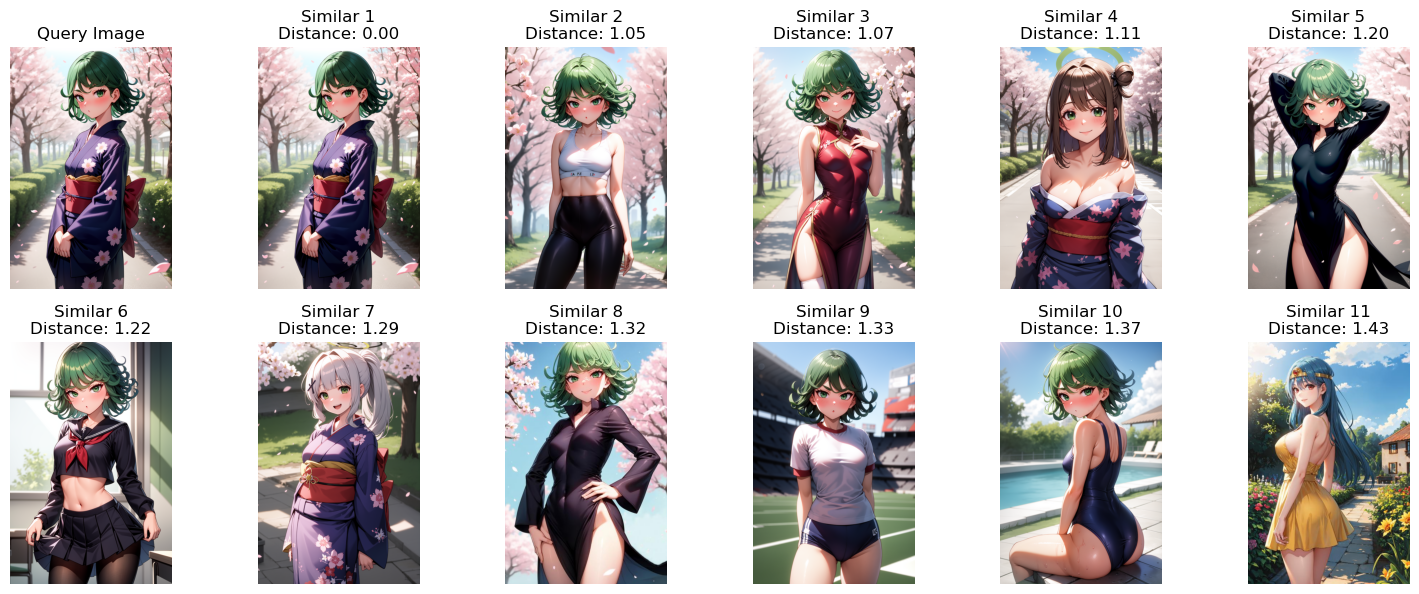

In [ ]:
k = 11

# Randomly select query images
# query_idx = random.choice(range(len(test_df)))
query_idx = 3456
query_image = Image.open(test_df.iloc[query_idx]['File Path']).convert('RGB')

# Search for similar images
distances, similar_indices = search_similar_images(index, features, query_idx, k)

# Acquire similar images
similar_images = [Image.open(test_df.iloc[idx]['File Path']).convert('RGB') for idx in similar_indices]

visualize_results(query_image, similar_images, distances)

Calculating distances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1305/1305 [00:47<00:00, 27.41it/s]


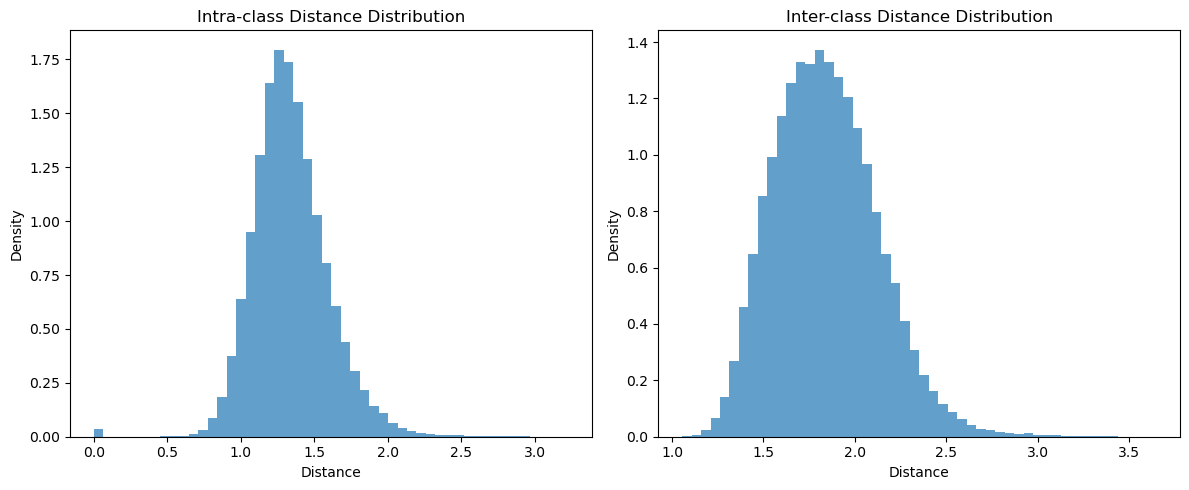

Intra-class distance: mean = 1.3377, std = 0.2588
Inter-class distance: mean = 1.8420, std = 0.2845


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def analyze_distances(model, dataloader, device):
    model.eval()
    features = []
    labels = []
    
    # Extract features and labels
    with torch.no_grad():
        acc =0

        for images, _, _ in tqdm(dataloader, desc="Extracting features"):
            images = images.to(device)
            output = model(images)
            features.append(output.cpu().numpy())
            idxs = np.arange(len(images)) + acc
            acc += len(images)

            labels.extend(dataloader.dataset.data.iloc[idxs]['Model ID'].tolist())
    
    features = np.vstack(features)
    labels = np.array(labels)
    
    intra_class_distances = []
    inter_class_distances = []
    
    for label in tqdm(np.unique(labels), desc="Calculating distances"):
        class_features = features[labels == label]
        other_features = features[labels != label]
        
        # Calculate intra-class distances
        if len(class_features) > 1:
            intra_distances = np.linalg.norm(class_features[:, None, :] - class_features[None, :, :], axis=-1)
            intra_class_distances.extend(intra_distances[np.triu_indices(len(class_features), k=1)])
        
        # Calculate inter-class distances (to 10 random samples from other classes)
        if len(other_features) > 0:
            random_indices = np.random.choice(len(other_features), min(10, len(other_features)), replace=False)
            inter_distances = np.linalg.norm(class_features[:, None, :] - other_features[random_indices][None, :, :], axis=-1)
            inter_class_distances.extend(inter_distances.flatten())
    
    # Plot distributions
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(intra_class_distances, bins=50, density=True, alpha=0.7)
    plt.title("Intra-class Distance Distribution")
    plt.xlabel("Distance")
    plt.ylabel("Density")
    
    plt.subplot(1, 2, 2)
    plt.hist(inter_class_distances, bins=50, density=True, alpha=0.7)
    plt.title("Inter-class Distance Distribution")
    plt.xlabel("Distance")
    plt.ylabel("Density")
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Intra-class distance: mean = {np.mean(intra_class_distances):.4f}, std = {np.std(intra_class_distances):.4f}")
    print(f"Inter-class distance: mean = {np.mean(inter_class_distances):.4f}, std = {np.std(inter_class_distances):.4f}")

# Usage example:
analyze_distances(model, test_loader, device)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import pairwise_distances

def calculate_hit_rates(model, dataloader, device):
    model.eval()
    features = []
    labels = []

    acc = 0
    
    # Extract features and labels
    with torch.no_grad():
        for images, _, _ in tqdm(dataloader, desc="Extracting features"):
            indexs = np.arange(len(images)) + acc
            images = images.to(device)
            output = model(images)
            features.append(output.cpu().numpy())
            labels.extend(dataloader.dataset.data.iloc[indexs]['Model ID'].tolist())
    
    features = np.vstack(features)
    labels = np.array(labels)
    
    # Calculate pairwise distances
    distances = pairwise_distances(features)
    
    top1_hits = 0
    top10_hits = 0
    total_queries = len(labels)
    
    for i in tqdm(range(total_queries), desc="Calculating hit rates"):
        # Sort distances, excluding the first one (distance to self)
        sorted_indices = np.argsort(distances[i])[1:]
        
        # Check top-1 hit (excluding self)
        if labels[sorted_indices[0]] == labels[i]:
            top1_hits += 1
        
        # Check top-10 hit (excluding self)
        if labels[i] in labels[sorted_indices[:10]]:
            top10_hits += 1
    
    top1_hit_rate = top1_hits / total_queries
    top10_hit_rate = top10_hits / total_queries
    
    print(f"Top-1 Hit Rate: {top1_hit_rate:.4f}")
    print(f"Top-10 Hit Rate: {top10_hit_rate:.4f}")
    
    return top1_hit_rate, top10_hit_rate

# Usage example:
top1_rate, top10_rate = calculate_hit_rates(model, test_loader, device)

Calculating hit rates: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12145/12145 [00:15<00:00, 778.25it/s]

Top-1 Hit Rate: 0.5883
Top-10 Hit Rate: 0.9489


Extracting features:   0%|                                                                                                                                                                                                                                                         | 0/380 [00:00<?, ?it/s]

Extracting features: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [01:13<00:00,  5.16it/s]
/tmp/ipykernel_1146735/3711001707.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10')  # 'tab10' provides 10 distinct colors


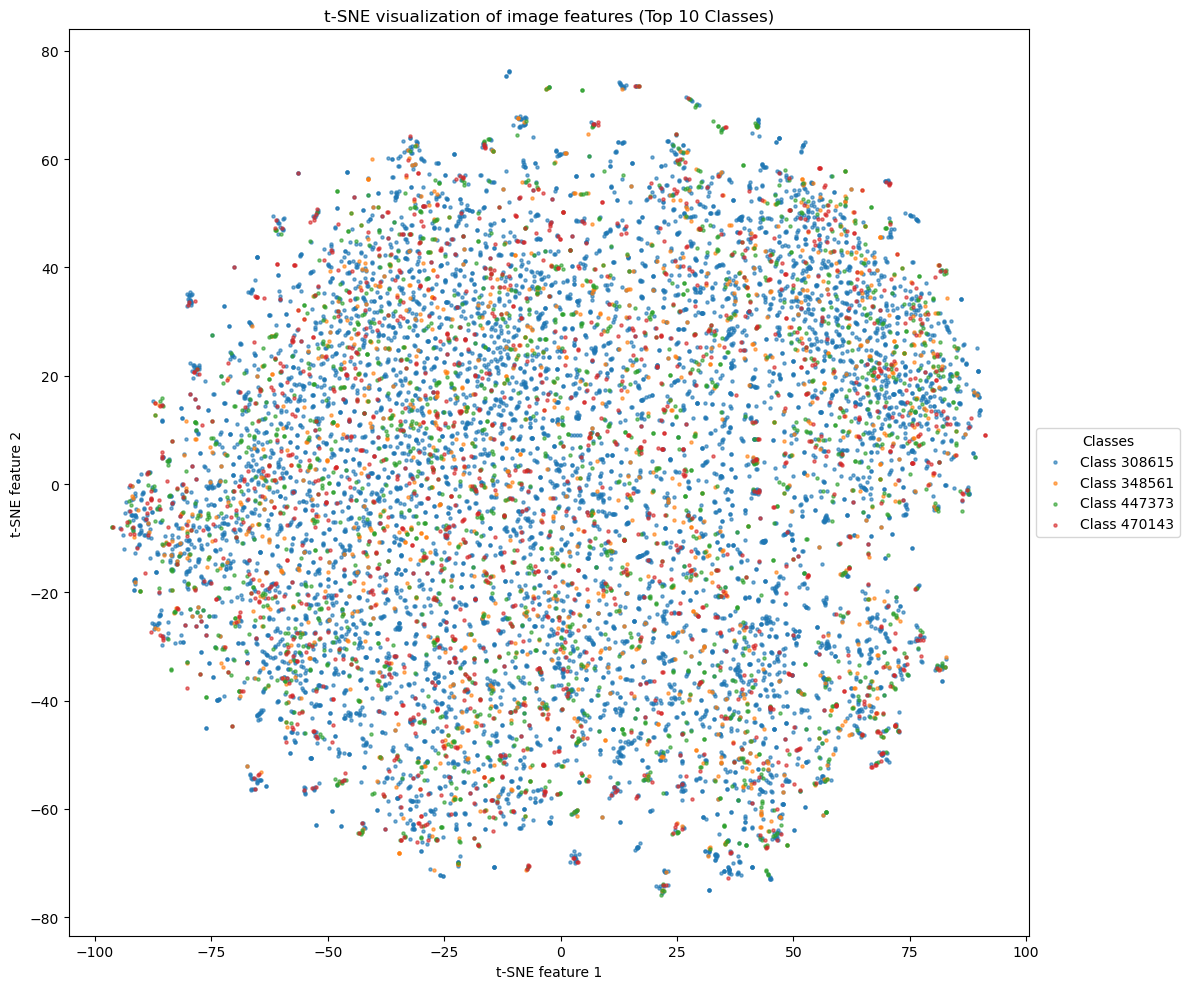

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from collections import Counter

def tsne_visualization_top10(model, dataloader, device, n_components=2, perplexity=30, n_iter=1000):
    model.eval()
    features = []
    labels = []

    acc = 0
    
    # Extract features and labels
    with torch.no_grad():
        for images, _, _ in tqdm(dataloader, desc="Extracting features"):
            indexes = np.arange(len(images)) + acc
            images = images.to(device)
            output = model(images)
            features.append(output.cpu().numpy())
            labels.extend(dataloader.dataset.data.iloc[indexes]['Model ID'].tolist())
    
    features = np.vstack(features)
    labels = np.array(labels)
    
    # Get top 10 most frequent classes
    class_counts = Counter(labels)
    top10_classes = [cls for cls, _ in class_counts.most_common(10)]
    
    # Filter data for top 10 classes
    mask = np.isin(labels, top10_classes)
    features_filtered = features[mask]
    labels_filtered = labels[mask]
    
    # Normalize features
    scaler = StandardScaler()
    features_normalized = scaler.fit_transform(features_filtered)
    
    # Perform t-SNE
    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter, random_state=42)
    tsne_results = tsne.fit_transform(features_normalized)
    
    # Prepare for plotting
    unique_labels = np.unique(labels_filtered)
    n_classes = len(unique_labels)
    
    # Create a color map
    color_map = plt.cm.get_cmap('tab10')  # 'tab10' provides 10 distinct colors
    colors = [color_map(i) for i in range(n_classes)]
    
    # Plot
    plt.figure(figsize=(12, 10))
    for i, label in enumerate(unique_labels):
        mask = labels_filtered == label
        plt.scatter(tsne_results[mask, 0], tsne_results[mask, 1], c=[colors[i]], label=f'Class {label}', alpha=0.6, s=5)
    
    plt.title('t-SNE visualization of image features (Top 10 Classes)')
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    
    plt.legend(title="Classes", loc="center left", bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    plt.savefig('tsne_visualization_top10.png', dpi=300, bbox_inches='tight')
    plt.show()

# Usage example:
tsne_visualization_top10(model, test_loader, device)

In [ ]:
distances = np.linalg.norm(features - features[0])
distances.shape, features.shape

((), (12145, 2048))

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 9.000e+00, 3.030e+02, 1.254e+03, 1.785e+03, 1.641e+03,
        1.290e+03, 9.020e+02, 7.430e+02, 5.940e+02, 4.970e+02, 4.490e+02,
        3.410e+02, 3.040e+02, 2.370e+02, 2.100e+02, 1.770e+02, 1.760e+02,
        1.530e+02, 1.360e+02, 1.290e+02, 1.130e+02, 7.200e+01, 6.200e+01,
        7.700e+01, 4.700e+01, 5.200e+01, 3.400e+01, 4.700e+01, 4.500e+01,
        3.100e+01, 2.100e+01, 1.800e+01, 1.000e+01, 9.000e+00, 1.900e+01,
        2.600e+01, 1.200e+01, 9.000e+00, 9.000e+00, 7.000e+00, 8.000e+00,
        5.000e+00, 1.200e+01, 1.100e+01, 8.000e+00, 4.000e+00, 4.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 4.000e+00, 2.000e+00, 4.000e+00,
        1.000e+00, 3.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 4.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+0

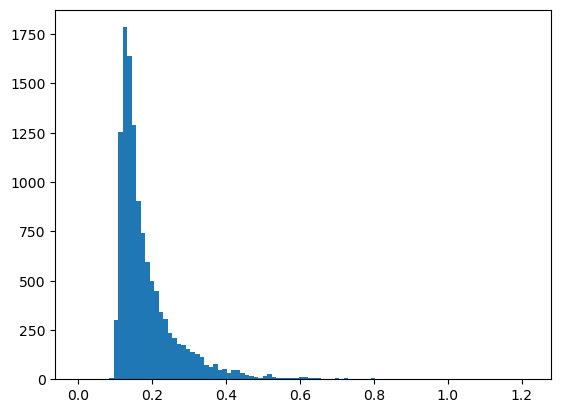

In [ ]:
plt.hist(np.linalg.norm(features - features[0], axis=1), bins=100)